# 1. Importing Libraries

In [1]:
import networkx as nx
import dwave_networkx as dnx
from dimod.reference.samplers import SimulatedAnnealingSampler
import geopandas as gpd
from geopy.distance import great_circle
from collections import defaultdict
import pandas as pd
from shapely import LineString
import matplotlib.pyplot as plt
import pyqubo

# 2. Defining the Graphs like in NB#2

In [2]:
# Setting up an empty graph
G = nx.Graph()

In [3]:
# Reading in the GeoJSON files of the edges and nodes as GeoPandas
gdf_nodes_json = gpd.read_file('../data/gdf_nodes.geojson')
gdf_edges_json = gpd.read_file('../data/gdf_edges.geojson')

Since our graph is huge and the quantum annealing task is running locally on our PCs, we will limit the graph to only include the nodes bounded within the Europe/Africa and South America box territory.

In [ ]:
europe_africa_box = {
    'lon_range': [-30, 10],   # From the mid-Atlantic to Eastern Europe
    'lat_range': [-10, 60]    # From south of the equator up to Northern Europe
}

south_america_box = {
    'lon_range': [-60, -25],  # From the middle of Brazil to the Atlantic
    'lat_range': [-40, 10]     # From northern Argentina up to north of the equator
}

In [5]:
def is_edge_in_bounds(geometry, box1, box2):
    """
    Checks if a LINESTRING has at least one endpoint inside one of the two boxes.
    """
    start_point = geometry.coords[0]
    end_point = geometry.coords[-1]

    # Check if start point is in either box
    start_in_bounds = ((box1['lon_range'][0] <= start_point[0] <= box1['lon_range'][1] and
                        box1['lat_range'][0] <= start_point[1] <= box1['lat_range'][1]) or
                       (box2['lon_range'][0] <= start_point[0] <= box2['lon_range'][1] and
                        box2['lat_range'][0] <= start_point[1] <= box2['lat_range'][1]))

    # Check if end point is in either box
    end_in_bounds = ((box1['lon_range'][0] <= end_point[0] <= box1['lon_range'][1] and
                      box1['lat_range'][0] <= end_point[1] <= box1['lat_range'][1]) or
                     (box2['lon_range'][0] <= end_point[0] <= box2['lon_range'][1] and
                      box2['lat_range'][0] <= end_point[1] <= box2['lat_range'][1]))

    return start_in_bounds or end_in_bounds

In [ ]:
# Create a boolean mask by applying our function to the 'geometry' column.
mask = gdf_edges_json['geometry'].apply(
    lambda geom: is_edge_in_bounds(geom, europe_africa_box, south_america_box)
)

# Apply the mask to create the new, smaller DataFrame
gdf_filtered = gdf_edges_json[mask]

In [7]:
# Creating graph G in NetworkX from the Geo DFs
G = nx.from_pandas_edgelist(
    gdf_filtered,
    source='start_node',
    target='end_node',
    edge_attr='weight'
)

node_positions = {
    row['node_id']: (row.geometry.x, row.geometry.y)
    for index, row in gdf_nodes_json.iterrows()
}
nx.set_node_attributes(G, node_positions, name='pos')

In [8]:
# Assigning coordinates for our cities & countries of interest
PORTUGAL_COORDS = (38.736946, -9.142685)  # (lat, lon) for Lisbon, Portugal
BRAZIL_COORDS = (-3.731862, -38.526669)   # (lat, lon) for Fortaleza, Brazil 

In [9]:
# Defining the function to find closest cable node to our cities of interest
def find_closest_node(graph, target_coords):

    target_lat, target_lon = target_coords
    closest_node_id = None
    min_dist = float('inf')

    # We iterate through all nodes and their data (attributes)
    for node_id, attributes in graph.nodes(data=True):
        node_lon, node_lat = attributes['pos']
        
        dist = great_circle((target_lat, target_lon), (node_lat, node_lon)).kilometers
        
        if dist < min_dist:
            min_dist = dist
            closest_node_id = node_id
            
    print(f"Found closest node for target {target_coords}: '{closest_node_id}' (Distance: {min_dist:.2f} km)")
    return closest_node_id

In [10]:
start_node = find_closest_node(G, PORTUGAL_COORDS)
end_node = find_closest_node(G, BRAZIL_COORDS)

Found closest node for target (38.736946, -9.142685): 'node_0310' (Distance: 1.41 km)
Found closest node for target (-3.731862, -38.526669): 'node_3539' (Distance: 2.32 km)


# 3. Task Description 
Our goal in this task is to build a specific QUBO function where the single lowest point corresponds exactly to the shortest path on our undersea cables map.

# 4. Building Blocks

Our function, `build_shortest_path_pyqubo`, is built from two main parts:

* **The Objective**: Making shorter paths have lower energy.

* **The Constraints**: Adding huge energy penalties for any solution that isn't a valid, continuous path.

First, how do we represent a path? We use binary variables: simple switches that can only be 0 (off) or 1 (on).

For our problem, we create a switch for every possible directed road segment on our map. An edge from node u to node v gets a variable we can call $x\_u,v$.

* If $x\_u,v=1$, it means "Yes, we are using the segment from u to v in our path."

* If $x\_u,v=0$, it means "No, we are not using that segment."

In [11]:
# Create a directed graph to model flow
D = G.to_directed()

# Create a Python dictionary to hold a pyqubo.Binary variable for each edge
x = { (u, v): pyqubo.Binary(f'x_{u},{v}') for u, v in D.edges() }

## 4.1 The Objective

We want the total energy to go up as the path gets longer. We do this by making a part of the energy equal to the path's total distance.

The mathematical formula for this is:

$$H_{Objective} = \sum_{\text{all edges (u,v)}} \text{distance}(u,v) \cdot x_{u,v}$$
​
Let's break this equation down:
* We go through every possible edge (u,v) on the map.
* We take the distance of that edge (its weight).
* We multiply it by its switch, $x\_u,v$.

If the switch is on ($x\_u,v=1$), we add its full distance to the total energy. If the switch is off ($x\_u,v=0$), we add nothing. A solver trying to minimize this energy will naturally prefer to turn "on" the switches for shorter edges.

In [13]:
# Set the Lagrange parameter for penalties (heuristic)
lagrange = sum(D.edges[e].get('weight', 1.0) for e in D.edges) * 4

# Set the objective func
objective_func = sum(D[u][v].get('weight', 1.0) * x[(u, v)] for u, v in D.edges())

## 4.2 The Constraints
A random collection of short edges is not a path. We need to enforce rules. We do this by adding a massive penalty energy if a rule is broken. We use a large number, lagrange (`P`), to make these penalties count.

**Rule 1: The Starting Node `(source)`** 

Exactly one path segment must leave the source node. We can state this as: `(Total paths leaving the source) - (Total paths entering the source) = 1`. To turn this into a penalty, we square the difference. The penalty is zero only when the rule is met.

$$H_{Source} = P \cdot \left( \sum_{\text{edges leaving s}} x_{s,v} - \sum_{\text{edges entering s}} x_{u,s} - 1 \right)^2$$

If the rule is met, the expression inside the parenthesis is $(1 - 0 - 1) = 0$. And $0^2 = 0$, thus no penalty is added. If two paths leave, it becomes $(2 - 0 - 1)^2 = 1^2 = 1$, and a large penalty `P` is added to the energy, making this a bad solution.

**Rule 2: The Ending Node `(target)`**

Exactly one path segment must enter the target node. This is the reverse of the source. `(Total paths entering) - (Total paths leaving) = 1`.

$$H_{Target} = P \cdot \left( \sum_{\text{edges entering t}} x_{u,t} - \sum_{\text{edges leaving t}} x_{t,v} - 1 \right)^2$$

The logic is the same: the penalty is zero only when this rule is perfectly satisfied.

**Rule 3: The Intermediate Nodes `(Everything Else)`**

For any node in the middle of the path, the number of segments entering it must equal the number of segments leaving it. This ensures the path is continuous ("flow conservation"). `(Total paths entering) - (Total paths leaving) = 0`.

$$H_{Intermediate} = P \cdot \left( \sum_{\text{edges in}} x_{u,n} - \sum_{\text{edges out}} x_{n,v} \right)^2$$

If a node has one path in and one path out, the expression is $(1 - 1)^2 = 0$. No penalty. If it's not on the path at all, it's $(0 - 0)^2 = 0$. Still no penalty. But if a path enters a node and stops (e.g., $1 - 0$), the penalty is applied.

In [14]:
# Set the constraints
constraint_func = 0
for node in D.nodes():

    edges_in = list(D.in_edges(node))
    edges_out = list(D.out_edges(node))

    flow_in = sum(x[(u, v)] for u, v in edges_in)
    flow_out = sum(x[(u, v)] for u, v in edges_out)

    if node == start_node:
        # Rule 1
        constraint_func += (flow_out - flow_in - 1)**2
    elif node == end_node:
        # Rule 2
        constraint_func += (flow_in - flow_out - 1)**2
    else:
        # Rule 3
        constraint_func += (flow_in - flow_out)**2


The final energy landscape, or Hamiltonian (H), is the sum of our goal and all of our rules.

$$H_{Total} = H_{Objective} + P \cdot (\text{All Constraint Penalties})$$

In [15]:
# Combine and compile
H = objective_func + lagrange * constraint_func
model = H.compile()

Next, we need to convert the model into a QUBO function and optimize it.

In [ ]:
# Converting the model to QUBO
qubo, offset = model.to_qubo()

# This step runs the QUBO optimization. 'neal' is a classical simulator
print("Solving the QUBO...")
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample_qubo(qubo, num_reads=100)

# We get the best sample from the first (lowest-energy) result in the sampleset
best_sample = sampleset.first.sample

print(f"Lowest energy found: {sampleset.first.energy}")

Solving the QUBO...
Lowest energy found: 169115.56389427185


In [ ]:
# Create a list of edges that the solver turned "on"
path_edges = []

for var, value in best_sample.items():
    if value == 1 and var.startswith('x_'):
        node_pair_str = var[2:]
        parts = node_pair_str.split(',')
        u, v = parts[0], parts[1]
        path_edges.append((u, v))

Let us uild a temporary directed graph from only the "on" edges.


In [19]:
# We create an empty DiGraph first
path_graph = nx.DiGraph()

# Then add only the edges from our list
path_graph.add_edges_from(path_edges)

d:\Software\Miniconda\envs\dsai_wu\Lib\site-packages\geopandas\geodataframe.py:1981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


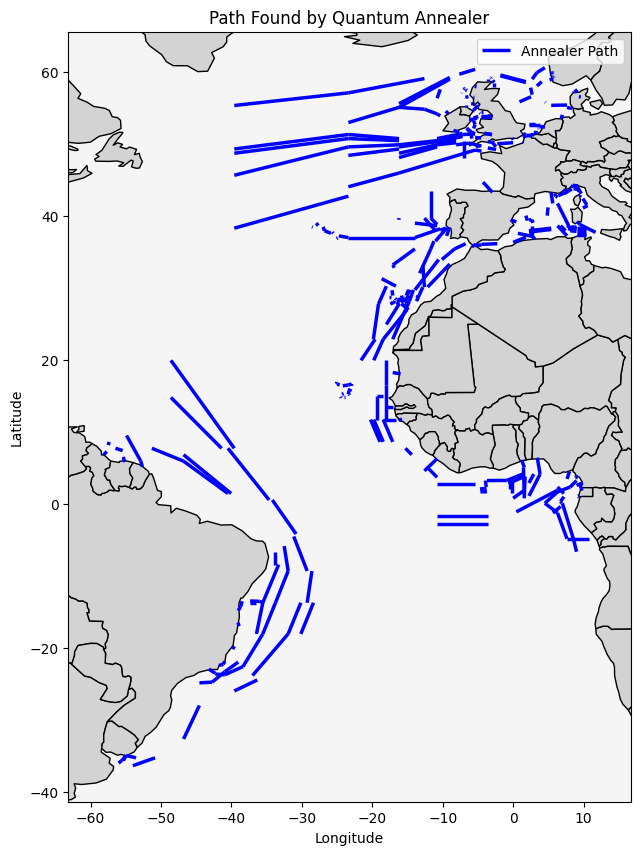

In [ ]:
solution_edges = list(path_graph.edges())

gdf_filtered['edge_tuple'] = [tuple(x) for x in gdf_filtered[['start_node', 'end_node']].values]
lines_to_plot = gdf_filtered[gdf_filtered['edge_tuple'].isin(solution_edges)]

world_shp_path = "../data/map_data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"
        
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_facecolor('whitesmoke')

world = gpd.read_file(world_shp_path)
world.plot(ax=ax, color="lightgray", edgecolor="black")

lines_to_plot.plot(ax=ax, color="blue", linewidth=2.5, label="Annealer Path")

xmin, ymin, xmax, ymax = lines_to_plot.total_bounds
ax.set_xlim(xmin - 5, xmax + 5)
ax.set_ylim(ymin - 5, ymax + 5)

ax.set_title("Path Found by Quantum Annealer")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()

# Results

We just encountered a limitation of the QUBO. 

When we increase the lagrange penalty `P` (from 1 to 2 to 4) to force the solver to obey the rules, this negative part becomes huge. The solver looks at each variable and sees: `Bias(x) = 500 - (2 * 4,000,000) = -7,999,500`. It concludes that setting `x=1` will drastically lower the total energy.

This happens for every edge. The negative pull from the constraint penalties completely overwhelms the positive cost from the edge weights, and the solver then **turns everything on**, believing this is the lowest-energy state. And it doesn't do so in an "arranged manner" (to reconstruct the actual undersea cable), but rather across the whole graph.

Therefore, we cannot identify a shortest path appropriately from Portugal to Brazil using our QUBO function. A better QUBO function can be structured to (perhaps) account for more constraints and force the model to identify the nodes in a structured path to reconstruct the actual undersea cable.

# Conclusion 
While we did not manage to build a proper quantum annealing model to identify the shortest path in a graph, this doesn't deem our task as useless. We found out that in this specific use case, the classic models that we did in the `2-classic-shortest-path.ipynb` notebook are performing just right. 

We will definitely come back to this task and further explore it with further findings.